In [ ]:
#Loan Default Prediction (Fintech) - using fintech_loan_default_dataset.csv
#Author: Daniel Godfrey

Loan Default Prediction (Fintech) - using fintech_loan_default_dataset.csv
Author: Daniel Godfrey **bold text**

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load dataset

# Make sure fintech_loan_default_dataset.csv is in the same folder as this script
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("fintech_loan_default_dataset.csv")

print("✅ Dataset loaded successfully")
print("Shape:", df.shape)
print(df.head())


Saving fintech_loan_default_dataset.csv to fintech_loan_default_dataset.csv
✅ Dataset loaded successfully
Shape: (20000, 16)
   customer_id  age gender    income  loan_amount  loan_term_months  \
0        10651   31      F   14124.0       3981.0                24   
1         2042   29      M   23658.0      12834.0                24   
2         8669   37      F   77502.0      16779.0                48   
3         1115   35      M   73866.0      17364.0                 6   
4        13903   33      F  174555.0      73690.0                36   

   interest_rate  credit_score  num_of_products  avg_monthly_balance  \
0          12.57           673                3               6672.0   
1           8.13           632                2              11740.0   
2          12.55           627                6              36573.0   
3           9.71           568                2              21938.0   
4          19.15           596                2              44100.0   

   num_tx_last_

In [3]:
# Basic EDA
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
customer_id              0
age                      0
gender                   0
income                   0
loan_amount              0
loan_term_months         0
interest_rate            0
credit_score             0
num_of_products          0
avg_monthly_balance      0
num_tx_last_30d          0
num_chargebacks          0
days_since_last_login    0
employment_type          0
has_previous_default     0
target_default           0
dtype: int64


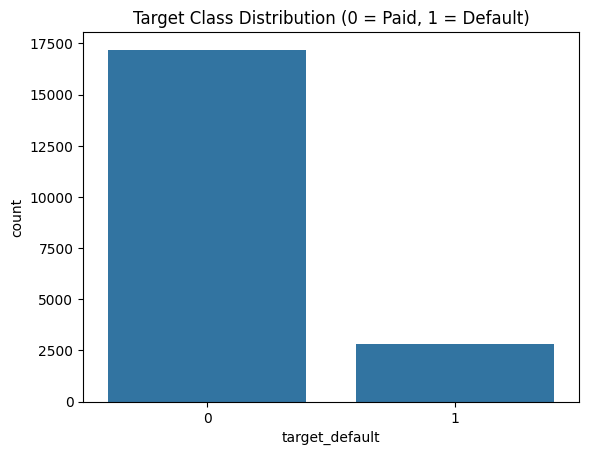

In [4]:
# Visualize class balance
sns.countplot(x='target_default', data=df)
plt.title("Target Class Distribution (0 = Paid, 1 = Default)")
plt.show()

In [5]:
# Split dataset
X = df.drop(columns=['customer_id', 'target_default'])
y = df['target_default']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [6]:
# Preprocessing pipeline
numeric_features = [
    'age', 'income', 'loan_amount', 'loan_term_months', 'interest_rate',
    'credit_score', 'num_of_products', 'avg_monthly_balance',
    'num_tx_last_30d', 'num_chargebacks', 'days_since_last_login'
]

categorical_features = ['gender', 'employment_type', 'has_previous_default']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [7]:
# Model pipelines
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=42))
])

In [8]:
# Train & evaluate models
def evaluate_model(name, model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    print(f"\n=== {name} ===")
    print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
    print("Average Precision (PR AUC):", average_precision_score(y_test, y_pred_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    RocCurveDisplay.from_predictions(y_test, y_pred_proba)
    plt.title(f"{name} - ROC Curve")
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
    plt.title(f"{name} - Precision-Recall Curve")
    plt.show()


=== Logistic Regression ===
ROC AUC: 0.9919253529900333
Average Precision (PR AUC): 0.9553907832339916
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3440
           1       0.76      0.96      0.85       560

    accuracy                           0.95      4000
   macro avg       0.88      0.95      0.91      4000
weighted avg       0.96      0.95      0.95      4000



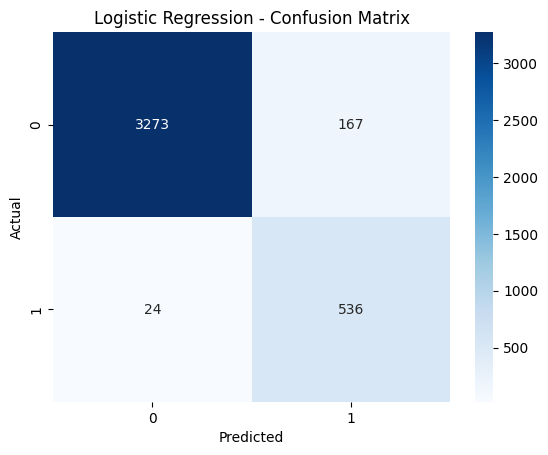

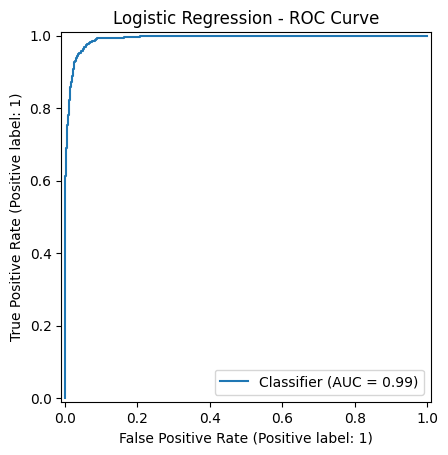

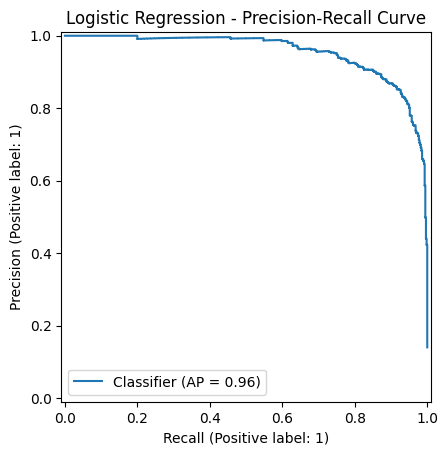

In [9]:
# Logistic Regression
lr_pipeline.fit(X_train, y_train)
evaluate_model("Logistic Regression", lr_pipeline, X_test, y_test)


=== Random Forest ===
ROC AUC: 0.993296303986711
Average Precision (PR AUC): 0.9630341211300173
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3440
           1       0.94      0.85      0.89       560

    accuracy                           0.97      4000
   macro avg       0.96      0.92      0.94      4000
weighted avg       0.97      0.97      0.97      4000



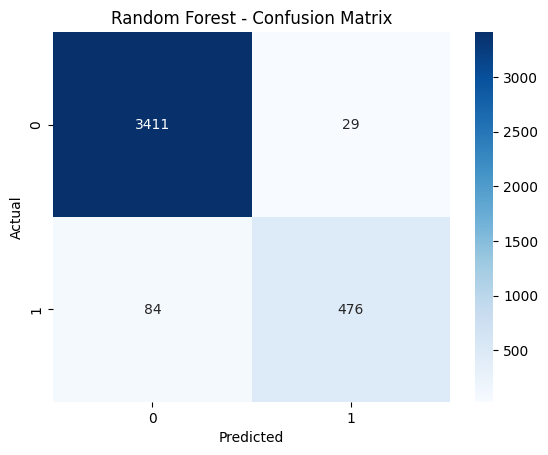

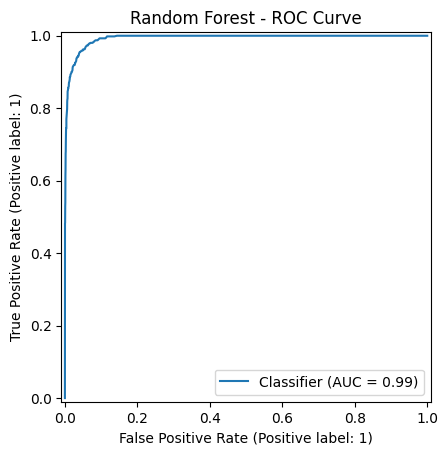

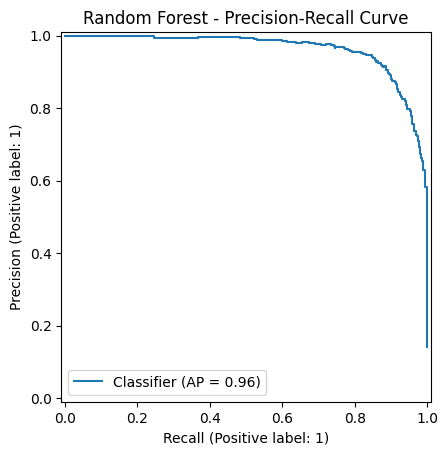

In [10]:
# Random Forest
rf_pipeline.fit(X_train, y_train)
evaluate_model("Random Forest", rf_pipeline, X_test, y_test)

In [11]:
# Save final model
final_model = rf_pipeline
final_model.fit(X, y)  # retrain on full dataset
joblib.dump(final_model, "loan_default_model.pkl")
print("\n Final model saved as loan_default_model.pkl")


 Final model saved as loan_default_model.pkl



Top 20 Features by Importance:
has_previous_default_1           0.317074
credit_score                     0.274167
num_chargebacks                  0.193192
loan_amount                      0.049745
income                           0.037590
avg_monthly_balance              0.025956
interest_rate                    0.023173
days_since_last_login            0.019141
age                              0.016532
num_tx_last_30d                  0.014248
num_of_products                  0.008928
loan_term_months                 0.008363
gender_F                         0.002531
gender_M                         0.002393
employment_type_self_employed    0.002240
employment_type_salaried         0.002202
employment_type_unemployed       0.001552
gender_O                         0.000973
dtype: float64


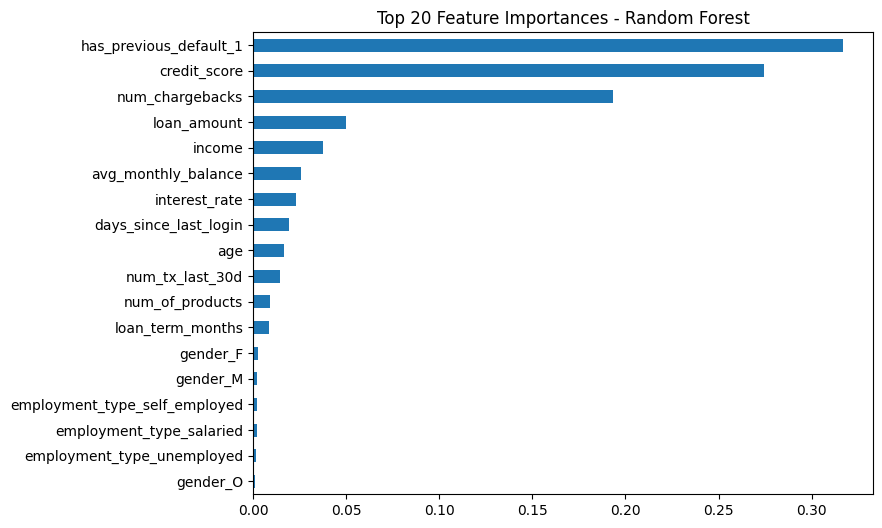

In [12]:
# Feature importance (for RandomForest)
preproc = final_model.named_steps['preprocessor']
num_features = numeric_features
cat_encoder = preproc.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_features])
importances = final_model.named_steps['classifier'].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
print("\nTop 20 Features by Importance:")
print(fi)

fi.plot(kind='barh', figsize=(8, 6))
plt.title("Top 20 Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.show()